# Reaction Time Experiment: 2^k Factorial Design with Blocking

Chosen design: full factorial design with blocking

This notebook analyzes a reaction time experiment using a 2^7 factorial design with 4 operators as blocks.

## Experimental Design

### Factors (k = 7):
1. **Minimum delay**: -1 = 0.5s, +1 = 2.0s
2. **Maximum delay**: -1 = 3.0s, +1 = 7.0s
3. **Frame motion**: -1 = static, +1 = shaking
4. **Background**: -1 = white, +1 = random colors
5. **Font scale**: -1 = small(42), +1 = large(72)
6. **Text color**: -1 = black, +1 = random colors
7. **Text motion**: -1 = static, +1 = moving

### Blocks (Operators):
- Sabina
- Florentin
- Francisco
- Petr

DEO table was randomized and than splitted in to 32 per one operator

### Response:
- Reaction time (ms) - 10 repetitions per condition



## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import OLSInfluence
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
import os
from io import StringIO

# Define file paths with local-first approach and GitHub fallback
data_files = {
    'Florentin': 'reaction_time_measurements_Florentin.csv',
    'Francisco': 'reaction_time_measurements_Francisco.csv',
    'Sabina': 'reaction_time_measurements_Sabina.csv',
    'Petr': 'reaction_time_petr.csv',
    'Centerpoints': 'reaction_time_center_point.csv'
}

base_url = 'https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/'

dfs = []
for operator, filename in data_files.items():
    local_path = filename
    if os.path.exists(local_path):
        # Read raw content first to handle malformed files
        with open(local_path, 'r') as f:
            content = f.read()
        print(f"Loaded {operator} from local file: {local_path}")
    else:
        try:
            import urllib.request
            url = base_url + filename
            with urllib.request.urlopen(url) as response:
                content = response.read().decode('utf-8')
            print(f"Loaded {operator} from GitHub: {url}")
        except Exception as e:
            print(f"Error loading {operator}: {e}")
            continue

    # Fix malformed Sabina file: first line has multiple records concatenated
    # Split by the header pattern and reconstruct
    lines = content.split('\n')
    header = 'timestamp_utc,participant,stimulus_type,font_size,motion,input_mode,frame_motion,shaking,text_color_mode,background_mode,min_delay_sec,max_delay_sec,repetitions,trial,stimulus,reaction_time_ms'

    # Check if first line is malformed (contains multiple records)
    if lines[0].count('timestamp_utc') > 1 or lines[0].count(',') > 20:
        print(f"  -> Fixing malformed first line in {operator}'s file...")
        # The first line might have header + multiple data records concatenated
        # Split by the date pattern to separate records
        import re
        first_line = lines[0]
        # Extract header
        fixed_lines = [header]
        # Find all records (they start with date pattern)
        records = re.split(r'(?=\d{4}-\d{2}-\d{2}T)', first_line)
        for rec in records:
            if rec.strip() and not rec.startswith('timestamp'):
                fixed_lines.append(rec.strip())
        # Add remaining lines
        for line in lines[1:]:
            if line.strip():
                fixed_lines.append(line.strip())
        content = '\n'.join(fixed_lines)

    # Parse CSV
    df = pd.read_csv(StringIO(content))

    # Ensure participant column is consistent
    df['participant'] = operator
    dfs.append(df)
    print(f"  -> {len(df)} rows loaded for {operator}")

# Combine all data
df_raw = pd.concat(dfs, ignore_index=True)
print(f"\nTotal rows: {len(df_raw)}")
print(f"Columns: {list(df_raw.columns)}")
print(f"\nRows per operator:")
print(df_raw['participant'].value_counts())

Loaded Florentin from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_measurements_Florentin.csv
  -> 320 rows loaded for Florentin
Loaded Francisco from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_measurements_Francisco.csv
  -> 320 rows loaded for Francisco
Loaded Sabina from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_measurements_Sabina.csv
  -> 322 rows loaded for Sabina
Loaded Petr from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_petr.csv
  -> 328 rows loaded for Petr
Loaded Centerpoints from GitHub: https://raw.githubusercontent.com/VojtasekP/NAEX_reaction_time/main/reaction_time_center_point.csv
  -> 160 rows loaded for Centerpoints

Total rows: 1450
Columns: ['timestamp_utc', 'participant', 'stimulus_type', 'font_size', 'motion', 'input_mode', 'frame_motion', 'shaking', 'text_color_mode', 'background

In [3]:
# Display first few rows
df_raw.head(10)

,timestamp_utc,participant,stimulus_type,font_size,motion,input_mode,frame_motion,shaking,text_color_mode,background_mode,min_delay_sec,max_delay_sec,repetitions,trial,stimulus,reaction_time_ms
0,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,1,C,2048.23
1,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,2,E,1227.94
2,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,3,V,1168.15
3,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,4,T,1121.69
4,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,5,A,897.19
5,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,6,F,826.01
6,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,7,D,889.86
7,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,8,O,1081.57
8,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,9,C,1154.58
9,2025-11-24T23:15:48.848679,Florentin,Letters,Large,Static,Text field + Enter,Static frame,False,Random colors,White,0.5,7.0,10,10,O,1357.55


## 2. Data Preprocessing and Factor Coding

Convert the experimental settings to coded factor levels (-1, +1).

In [4]:
# Create a copy for analysis
df = df_raw.copy()

# --- MODIFIED CODING SECTION ---

# Factor 1: Min delay (Low < 1.0, High > 1.5 -> Middle is 0)
df['A_min_delay'] = df['min_delay_sec'].apply(lambda x: -1 if x < 1.0 else (1 if x > 1.5 else 0))

# Factor 2: Max delay (Low < 4.0, High > 6.0 -> Middle is 0)
df['B_max_delay'] = df['max_delay_sec'].apply(lambda x: -1 if x < 4.0 else (1 if x > 6.0 else 0))

# Factor 3: Frame motion (Binary)
df['C_frame_motion'] = df['frame_motion'].apply(lambda x: 1 if 'Shaking' in str(x) else -1)

# Factor 4: Background (Binary)
df['D_background'] = df['background_mode'].apply(lambda x: 1 if 'Random' in str(x) else -1)

# Factor 5: Font scale (Small=-1, Large=1 -> Anything else/Medium is 0)
df['E_font_scale'] = df['font_size'].apply(lambda x: 1 if 'Large' in str(x) else (-1 if 'Small' in str(x) else 0))

# Factor 6: Text color (Binary)
df['F_text_color'] = df['text_color_mode'].apply(lambda x: 1 if 'Random' in str(x) else -1)

# Factor 7: Text motion (Binary)
df['G_text_motion'] = df['motion'].apply(lambda x: 1 if 'Moving' in str(x) else -1)

# -------------------------------

# Block: Operator/Participant
df['Block'] = df['participant']

# Response: reaction time
df['Y'] = df['reaction_time_ms']

# Filter warmup trials
df = df[df['trial'] > 2]

print("Factor coding complete")
print("\nFactor summary (Check for 0s in A, B, E):")
for col in ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background', 'E_font_scale', 'F_text_color', 'G_text_motion']:
    print(f"{col}: {df[col].value_counts().to_dict()}")

Factor coding complete

Factor summary (Check for 0s in A, B, E):
A_min_delay: {-1: 518, 1: 512, 0: 128}
B_max_delay: {-1: 518, 1: 512, 0: 128}
C_frame_motion: {-1: 582, 1: 576}
D_background: {1: 582, -1: 576}
E_font_scale: {-1: 518, 1: 512, 0: 128}
F_text_color: {1: 582, -1: 576}
G_text_motion: {1: 582, -1: 576}


In [5]:
# Create unique experimental condition identifier
df['condition'] = (df['A_min_delay'].astype(str) + '_' +
                   df['B_max_delay'].astype(str) + '_' +
                   df['C_frame_motion'].astype(str) + '_' +
                   df['D_background'].astype(str) + '_' +
                   df['E_font_scale'].astype(str) + '_' +
                   df['F_text_color'].astype(str) + '_' +
                   df['G_text_motion'].astype(str))

# Count unique conditions per block
print("Unique conditions per block:")
print(df.groupby('Block')['condition'].nunique())

print(f"\nTotal unique conditions: {df['condition'].nunique()}")

Unique conditions per block:
Block
Centerpoints    16
Florentin       32
Francisco       32
Petr            32
Sabina          32
Name: condition, dtype: int64

Total unique conditions: 144


## 3. Aggregate Data by Condition

Average reaction times over the 10 repetitions per condition.

In [6]:
# Aggregate: mean reaction time per condition per block
factors = ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background',
           'E_font_scale', 'F_text_color', 'G_text_motion', 'Block']

df_agg = df.groupby(factors).agg(
    Y_mean=('Y', 'mean'),
    Y_median=('Y', 'median'),
    Y_std=('Y', 'std'),
    Y_count=('Y', 'count')
).reset_index()

print(f"Aggregated data shape: {df_agg.shape}")
print(f"\nConditions per block:")
print(df_agg.groupby('Block').size())

df_agg.head(10)

df_cp = df_agg[df_agg['Block']=='Centerpoints']
df_agg = df_agg[df_agg['Block']!='Centerpoints']

Aggregated data shape: (144, 12)

Conditions per block:
Block
Centerpoints    16
Florentin       32
Francisco       32
Petr            32
Sabina          32
dtype: int64


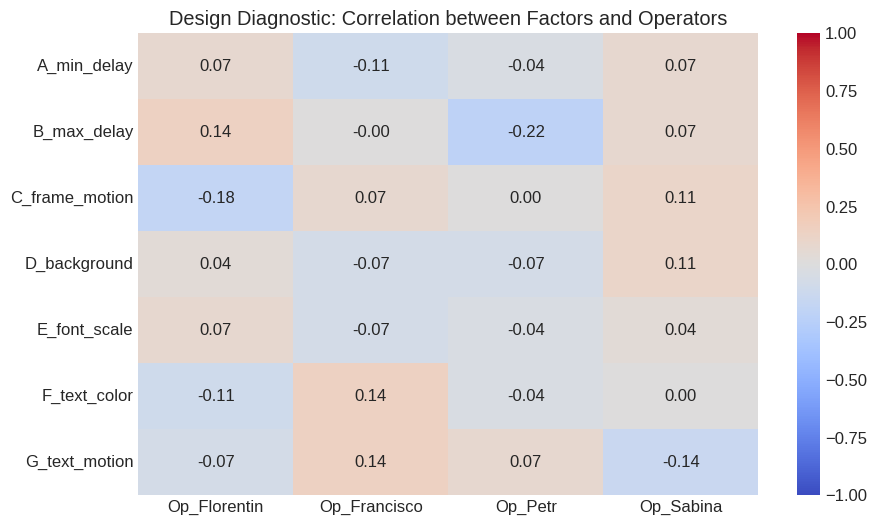

Max Absolute Correlation: 0.2165063509461096
CRITICAL WARNING: Significant non-orthogonality detected.
You cannot analyze this as a standard factorial design.
You must use regression (ANCOVA/GLM) adjusting for Block.


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_agg is already created as per your snippet

# 1. One-Hot Encode the Blocks to check correlation against numeric factors
# We drop_first=False to see all operators, though they are linearly dependent
df_check = df_agg.copy()
block_dummies = pd.get_dummies(df_check['Block'], prefix='Op')
factors_cols = ['A_min_delay', 'B_max_delay', 'C_frame_motion',
                'D_background', 'E_font_scale', 'F_text_color', 'G_text_motion']

# 2. Combine Factors and Block Dummies
design_matrix = pd.concat([df_check[factors_cols], block_dummies], axis=1)

# 3. Calculate Correlation Matrix
# We only care about the correlation between Factors (Rows) and Operators (Cols)
corr_matrix = design_matrix.corr()
factor_block_corr = corr_matrix.loc[factors_cols, block_dummies.columns]

# 4. Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(factor_block_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Design Diagnostic: Correlation between Factors and Operators")
plt.show()

# 5. Critical Check
# If any value is NOT 0.00, that factor is partially confounded with that operator.
print("Max Absolute Correlation:", np.abs(factor_block_corr.values).max())

if np.abs(factor_block_corr.values).max() > 0.1:
    print("CRITICAL WARNING: Significant non-orthogonality detected.")
    print("You cannot analyze this as a standard factorial design.")
    print("You must use regression (ANCOVA/GLM) adjusting for Block.")
else:
    print("Design is reasonably orthogonal.")

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix

# 1. Create the design matrix (Right-hand side of formula)
# ensuring we use the Coded variables
formula_vif = "C_frame_motion + D_background + E_font_scale + F_text_color + G_text_motion + C(Block)"
X = dmatrix(formula_vif, data=df_agg, return_type='dataframe')

# 2. Calculate VIF for each factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 Feature       VIF
0              Intercept  4.181096
1  C(Block)[T.Francisco]  1.626678
2       C(Block)[T.Petr]  1.549894
3     C(Block)[T.Sabina]  1.562933
4         C_frame_motion  1.039279
5           D_background  1.018815
6           E_font_scale  1.010634
7           F_text_color  1.027313
8          G_text_motion  1.042204


In [9]:
# @title
import pandas as pd
from io import StringIO

# --- 1. SETUP: READABLE LABELS ---
factor_labels = {
    0: {'name': 'MinDelay',    '-1': '0.5s',      '1': '2.0s'},
    1: {'name': 'MaxDelay',    '-1': '3.0s',      '1': '7.0s'},
    2: {'name': 'Frame',       '-1': 'Static',    '1': 'Shaking'},
    3: {'name': 'Background',  '-1': 'White',     '1': 'Random'},
    4: {'name': 'Font',        '-1': 'Small',     '1': 'Large'},
    5: {'name': 'TextColor',   '-1': 'Black',     '1': 'Random'},
    6: {'name': 'TextMotion',  '-1': 'Static',    '1': 'Moving'}
}

def decode_condition(cond_str):
    if pd.isna(cond_str): return "N/A"
    parts = cond_str.split('_')
    if len(parts) != 7: return cond_str
    readable = [factor_labels[i].get(part, part) for i, part in enumerate(parts)]
    return ", ".join(readable)

# --- 2. LOAD DOE TABLE ---
doe_string = """Operator,Run Order,minimum delay,motion,background,font scae,text color,frame motion,maximum delay
Sabina,1,1,-1,-1,-1,1,-1,1
Sabina,2,1,-1,1,1,-1,1,-1
Sabina,3,-1,-1,1,-1,1,1,-1
Sabina,4,1,-1,-1,-1,1,1,1
Sabina,5,1,1,-1,-1,1,-1,1
Sabina,6,1,-1,-1,-1,-1,1,1
Sabina,7,1,1,1,1,-1,-1,1
Sabina,8,-1,1,-1,-1,1,1,1
Sabina,9,-1,-1,1,-1,-1,1,-1
Sabina,10,1,-1,1,1,1,-1,-1
Sabina,11,-1,-1,1,-1,1,-1,1
Sabina,12,1,-1,1,-1,1,1,-1
Sabina,13,1,-1,1,1,-1,-1,1
Sabina,14,1,1,1,1,-1,1,1
Sabina,15,1,1,1,-1,1,-1,1
Sabina,16,1,1,1,1,-1,-1,-1
Sabina,17,-1,1,-1,1,1,-1,-1
Sabina,18,1,1,-1,-1,1,1,-1
Sabina,19,-1,1,1,1,-1,1,1
Sabina,20,-1,-1,1,-1,-1,-1,-1
Sabina,21,-1,-1,-1,1,1,1,1
Sabina,22,1,-1,-1,1,-1,1,1
Sabina,23,-1,1,1,-1,-1,1,1
Sabina,24,-1,-1,1,1,-1,1,-1
Sabina,25,1,-1,1,-1,1,1,1
Sabina,26,1,-1,-1,1,-1,-1,1
Sabina,27,-1,-1,-1,-1,-1,1,-1
Sabina,28,-1,-1,-1,1,1,1,-1
Sabina,29,-1,-1,1,1,1,-1,-1
Sabina,30,1,-1,1,1,1,1,1
Sabina,31,-1,1,1,1,-1,1,-1
Sabina,32,1,1,-1,1,-1,-1,1
Florentine,33,-1,-1,-1,1,1,-1,1
Florentine,34,1,-1,-1,1,-1,-1,-1
Florentine,35,-1,1,1,-1,-1,-1,1
Florentine,36,1,1,1,1,1,-1,-1
Florentine,37,1,1,1,-1,1,-1,-1
Florentine,38,1,1,1,-1,-1,-1,-1
Florentine,39,1,-1,-1,1,-1,1,-1
Florentine,40,-1,1,-1,1,1,-1,1
Florentine,41,-1,1,-1,1,-1,-1,1
Florentine,42,1,-1,1,1,-1,1,1
Florentine,43,1,-1,-1,-1,-1,-1,-1
Florentine,44,1,1,-1,1,1,-1,1
Florentine,45,1,-1,1,-1,-1,1,1
Florentine,46,-1,-1,1,1,1,-1,1
Florentine,47,1,1,1,-1,-1,1,-1
Florentine,48,1,-1,-1,-1,1,1,-1
Florentine,49,-1,-1,1,1,-1,-1,-1
Florentine,50,1,-1,-1,-1,-1,1,-1
Florentine,51,1,-1,-1,1,1,1,1
Florentine,52,-1,-1,1,-1,-1,-1,1
Florentine,53,-1,-1,1,1,-1,1,1
Florentine,54,1,-1,-1,-1,-1,-1,1
Florentine,55,-1,1,-1,-1,-1,-1,1
Florentine,56,-1,1,1,1,-1,-1,-1
Florentine,57,-1,1,-1,1,1,1,-1
Florentine,58,-1,1,1,1,1,-1,1
Florentine,59,1,1,1,-1,-1,-1,1
Florentine,60,1,-1,-1,1,1,-1,1
Florentine,61,1,1,1,-1,1,1,1
Florentine,62,-1,-1,1,1,-1,-1,1
Florentine,63,1,-1,1,1,1,-1,1
Florentine,64,-1,-1,-1,-1,-1,1,1
Francisco,65,1,-1,-1,1,1,1,-1
Francisco,66,-1,1,1,1,1,1,-1
Francisco,67,-1,1,1,-1,1,-1,1
Francisco,68,1,-1,-1,1,1,-1,-1
Francisco,69,1,-1,1,-1,-1,-1,1
Francisco,70,-1,1,1,-1,1,1,-1
Francisco,71,-1,-1,1,-1,1,1,1
Francisco,72,1,1,-1,-1,-1,-1,1
Francisco,73,1,1,-1,-1,-1,1,1
Francisco,74,1,1,-1,1,1,1,-1
Francisco,75,-1,1,1,-1,1,1,1
Francisco,76,1,1,-1,1,-1,-1,-1
Francisco,77,1,1,-1,1,1,1,1
Francisco,78,1,1,1,1,1,-1,1
Francisco,79,1,-1,1,1,1,1,-1
Francisco,80,-1,1,1,1,1,-1,-1
Francisco,81,-1,-1,-1,-1,-1,-1,1
Francisco,82,-1,1,-1,-1,-1,1,1
Francisco,83,-1,1,-1,-1,1,-1,-1
Francisco,84,1,1,-1,-1,1,1,1
Francisco,85,-1,1,1,1,1,1,1
Francisco,86,1,1,-1,1,-1,1,-1
Francisco,87,-1,-1,-1,1,-1,1,-1
Francisco,88,-1,-1,-1,-1,1,-1,1
Francisco,89,-1,1,1,-1,-1,-1,-1
Francisco,90,-1,-1,-1,1,-1,-1,-1
Francisco,91,-1,1,1,-1,-1,1,-1
Francisco,92,-1,-1,-1,-1,1,1,1
Francisco,93,-1,1,-1,1,1,1,1
Francisco,94,-1,1,-1,-1,-1,1,-1
Francisco,95,-1,-1,1,-1,1,-1,-1
Francisco,96,1,-1,1,-1,1,-1,1
Petr,97,1,-1,-1,-1,1,-1,-1
Petr,98,1,1,-1,1,-1,1,1
Petr,99,1,1,1,1,-1,1,-1
Petr,100,-1,-1,-1,-1,1,1,-1
Petr,101,1,1,1,1,1,1,-1
Petr,102,-1,-1,1,1,1,1,-1
Petr,103,-1,1,1,1,-1,-1,1
Petr,104,1,1,-1,1,1,-1,-1
Petr,105,-1,1,-1,-1,-1,-1,-1
Petr,106,-1,-1,-1,-1,-1,-1,-1
Petr,107,1,-1,1,-1,-1,-1,-1
Petr,108,-1,1,-1,-1,1,1,-1
Petr,109,-1,-1,-1,1,1,-1,-1
Petr,110,-1,1,-1,1,-1,1,1
Petr,111,-1,1,1,-1,1,-1,-1
Petr,112,-1,-1,-1,1,-1,1,1
Petr,113,-1,-1,-1,-1,1,-1,-1
Petr,114,1,1,-1,-1,-1,1,-1
Petr,115,1,1,-1,-1,1,-1,-1
Petr,116,1,-1,1,-1,1,-1,-1
Petr,117,1,1,1,-1,1,1,-1
Petr,118,-1,-1,1,1,1,1,1
Petr,119,1,1,-1,-1,-1,-1,-1
Petr,120,-1,-1,1,-1,-1,1,1
Petr,121,-1,1,-1,1,-1,1,-1
Petr,122,1,1,1,-1,-1,1,1
Petr,123,1,-1,1,-1,-1,1,-1
Petr,124,-1,1,-1,-1,1,-1,1
Petr,125,1,-1,1,1,-1,-1,-1
Petr,126,-1,-1,-1,1,-1,-1,1
Petr,127,1,1,1,1,1,1,1
Petr,128,-1,1,-1,1,-1,-1,-1
"""
doe = pd.read_csv(StringIO(doe_string))

col_map = {
    'minimum delay': 'A_min_delay',
    'maximum delay': 'B_max_delay',
    'frame motion': 'C_frame_motion',
    'background': 'D_background',
    'font scae': 'E_font_scale',
    'text color': 'F_text_color',
    'motion': 'G_text_motion'
}
doe.rename(columns=col_map, inplace=True)
doe['Operator_Clean'] = doe['Operator'].str.replace('Florentine', 'Florentin').str.strip()

# 3. GLOBAL LOOKUP MAP
# Condition String -> {Operator: 'Name', RunOrder: 123}
doe['condition'] = (doe['A_min_delay'].astype(str) + '_' +
                    doe['B_max_delay'].astype(str) + '_' +
                    doe['C_frame_motion'].astype(str) + '_' +
                    doe['D_background'].astype(str) + '_' +
                    doe['E_font_scale'].astype(str) + '_' +
                    doe['F_text_color'].astype(str) + '_' +
                    doe['G_text_motion'].astype(str))

global_doe_map = doe.set_index('condition')[['Operator_Clean', 'Run Order']].to_dict('index')

# --- 4. PREPARE ACTUAL DATA ---
# (df must be loaded)
df_runs = df.groupby(['participant', 'timestamp_utc', 'condition']).agg(
    trial_count=('reaction_time_ms', 'count')
).reset_index()
df_runs['Operator_Clean'] = df_runs['participant'].str.strip()

# --- 5. EXECUTE FILTERED AUDIT ---
print("\n" + "="*80)
print("CRITICAL ERROR REPORT: CROSS-BLOCK CONTAMINATION".center(80))
print("(Ignoring sequence shuffling within the correct block)".center(80))
print("="*80 + "\n")

errors_found = False

for operator in doe['Operator_Clean'].unique():
    # Get actual runs performed by this operator
    actual_runs = df_runs[df_runs['Operator_Clean'] == operator]

    # Sort by time just for reporting readability
    actual_runs = actual_runs.sort_values('timestamp_utc')

    print(f"🔹 Checking {operator} ({len(actual_runs)} runs performed)...")

    op_errors = 0

    for idx, row in actual_runs.iterrows():
        act_cond = row['condition']
        t_stamp = row['timestamp_utc']

        # Check against global map
        if act_cond in global_doe_map:
            meta = global_doe_map[act_cond]
            owner = meta['Operator_Clean']
            run_id = meta['Run Order']

            # THE LOGIC: If owner is different, it's a critical error
            if owner != operator:
                op_errors += 1
                errors_found = True

                print(f"   ❌ CRITICAL ERROR at {t_stamp}")
                print(f"      Performed Condition: {decode_condition(act_cond)}")
                print(f"      -> BELONGS TO:  {owner} (Block Run #{run_id})")
                print("-" * 50)

        else:
            # Condition doesn't exist in the DOE at all
            op_errors += 1
            errors_found = True
            print(f"   ❌ UNKNOWN CONDITION at {t_stamp}")
            print(f"      Performed: {decode_condition(act_cond)}")
            print(f"      -> This condition is not in the DOE for ANYONE.")
            print("-" * 50)

    if op_errors == 0:
        print("   ✅ No cross-block errors found.")
    print("")

if not errors_found:
    print("\n🎉 SUCCESS: All operators stayed within their assigned blocks (order may vary).")
else:
    print("\n⚠️  WARNING: Critical cross-block contaminations detected above.")


                CRITICAL ERROR REPORT: CROSS-BLOCK CONTAMINATION                
             (Ignoring sequence shuffling within the correct block)             

🔹 Checking Sabina (32 runs performed)...
   ✅ No cross-block errors found.

🔹 Checking Florentin (32 runs performed)...
   ✅ No cross-block errors found.

🔹 Checking Francisco (32 runs performed)...
   ✅ No cross-block errors found.

🔹 Checking Petr (32 runs performed)...
   ✅ No cross-block errors found.


🎉 SUCCESS: All operators stayed within their assigned blocks (order may vary).


## 4. Exploratory Data Analysis

In [10]:
# Summary statistics by block
print("Summary statistics by Block (Operator):")
print(df_agg.groupby('Block')['Y_median'].describe())

Summary statistics by Block (Operator):
           count         mean         std      min         25%        50%  \
Block                                                                       
Florentin   32.0  1164.724531  192.131444  857.445  1053.94625  1117.4825   
Francisco   32.0   808.463125   79.348029  668.530   749.09750   803.6700   
Petr        32.0  1032.992813  110.394768  731.865   972.71750  1070.4850   
Sabina      32.0  1030.781094   72.129088  897.155   995.59625  1028.0700   

                  75%       max  
Block                            
Florentin  1252.66375  1704.980  
Francisco   862.67000   995.030  
Petr       1097.46625  1236.875  
Sabina     1072.57125  1212.390  


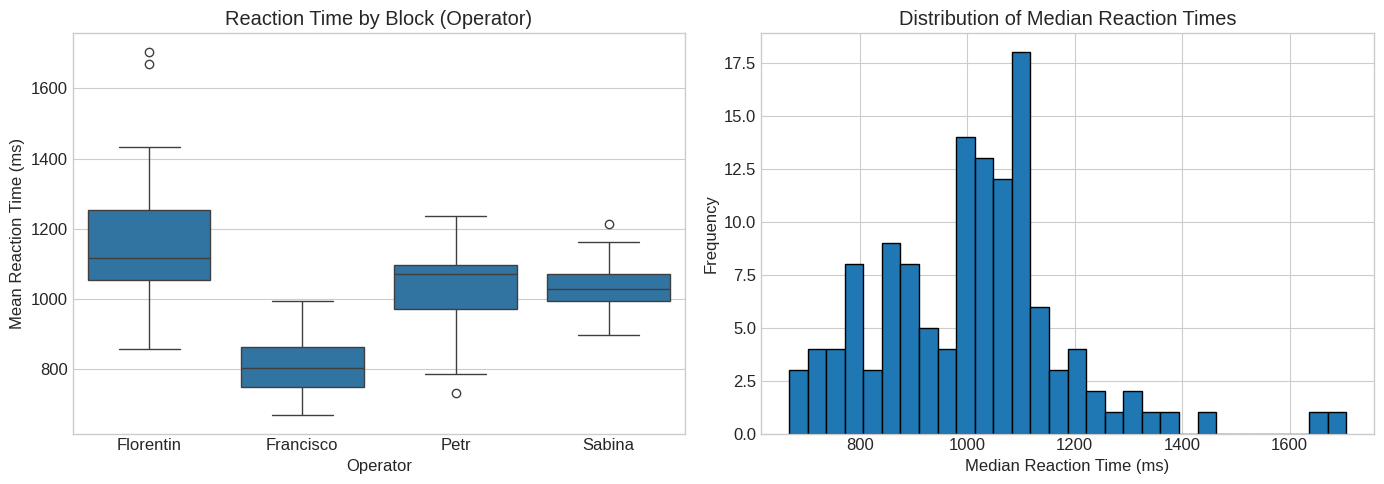


INTERPRETATION - Exploratory Data Analysis:
1. OPERATOR VARIABILITY:
   - Boxplots show differences in reaction times between operators
   - Some differences may be statistically significant (see ANOVA below)
   - Blocking by operator is justified - eliminates inter-personal variability

2. DISTRIBUTION:
   - Histogram shows slightly right-skewed distribution (typical for RT data)
   - Most reaction times are between 900-1400 ms
   - Some extremes (>2000 ms) may indicate attention loss or errors



In [11]:
# Box plot of reaction times by block
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By block - explicit order
block_order = ['Florentin', 'Francisco', 'Petr', 'Sabina']
sns.boxplot(x='Block', y='Y_median', data=df_agg, order=block_order, ax=axes[0])
axes[0].set_title('Reaction Time by Block (Operator)')
axes[0].set_xlabel('Operator')
axes[0].set_ylabel('Mean Reaction Time (ms)')

# Distribution
df_agg['Y_median'].hist(bins=30, ax=axes[1], edgecolor='black')
axes[1].set_title('Distribution of Median Reaction Times')
axes[1].set_xlabel('Median Reaction Time (ms)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Commentary on EDA
print("""
INTERPRETATION - Exploratory Data Analysis:
================================================================================
1. OPERATOR VARIABILITY:
   - Boxplots show differences in reaction times between operators
   - Some differences may be statistically significant (see ANOVA below)
   - Blocking by operator is justified - eliminates inter-personal variability

2. DISTRIBUTION:
   - Histogram shows slightly right-skewed distribution (typical for RT data)
   - Most reaction times are between 900-1400 ms
   - Some extremes (>2000 ms) may indicate attention loss or errors
""")

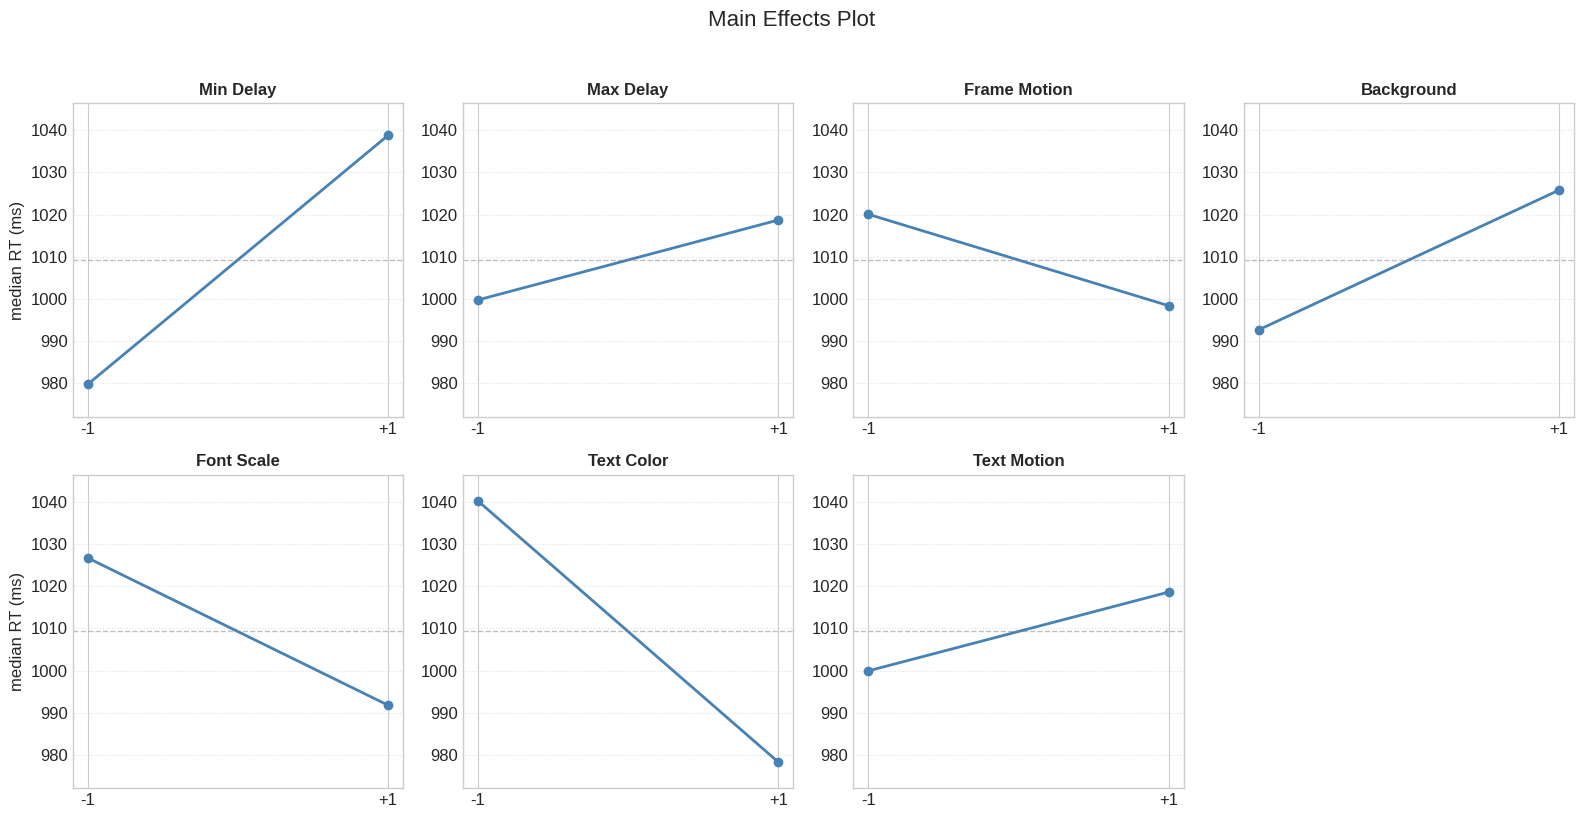

In [12]:
import matplotlib.pyplot as plt

# Main effects visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

factor_names = ['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background',
                'E_font_scale', 'F_text_color', 'G_text_motion']

factor_labels = ['Min Delay', 'Max Delay', 'Frame Motion', 'Background',
                 'Font Scale', 'Text Color', 'Text Motion']

# 1. Calculate Grand Mean and dynamic Y-limits for consistent scaling
grand_mean = df_agg['Y_median'].mean()

# Collect all group means first to determine the scale
all_means = []
for factor in factor_names:
    all_means.extend(df_agg.groupby(factor)['Y_median'].mean().values)

y_min, y_max = min(all_means), max(all_means)
y_margin = (y_max - y_min) * 0.1 # Add 10% padding

for i, (factor, label) in enumerate(zip(factor_names, factor_labels)):
    ax = axes[i // 4, i % 4]

    # Calculate means
    means = df_agg.groupby(factor)['Y_median'].mean()

    # 2. Plot Lines (Marker 'o' clarifies the exact measurement point)
    ax.plot(means.index.astype(str), means.values, marker='o', linewidth=2, color='steelblue')

    # 3. Add Grand Mean reference line
    ax.axhline(grand_mean, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Grand Mean')

    # Styling
    ax.set_title(f'{label}', fontsize=12, fontweight='bold')
    ax.set_ylim(y_min - y_margin, y_max + y_margin) # Enforce consistent scale
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['-1', '+1'])
    ax.grid(True, axis='y', linestyle=':', alpha=0.6)

    # Only set Y-label for the first column to reduce clutter
    if i % 4 == 0:
        ax.set_ylabel('median RT (ms)')

# Hide the last empty subplot
axes[1, 3].set_visible(False)

plt.suptitle('Main Effects Plot', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Before running the formal analysis, we did some exploratory plots to get a feel for the data. The Main Effects Plot gave us a quick look at which factors might be important. It was pretty clear right away that some settings made a real difference: a larger Font Scale seemed to make us faster, while turning on Text Motion or increasing the Min Delay slowed us down. Other factors, like Max Delay, looked like they had almost no effect at all. This initial look gave us a good idea of which variables were likely to show up as significant later on.

The most important insight though, came from the boxplot comparing the four of us as operators. The plot showed a huge difference in our natural reaction speeds—it was obvious that the person performing the test was a massive source of variation in the data. This was the perfect visual proof that the decision to "block" the experiment by operator was absolutely necessary. If we hadn't, the noise from our individual differences would have likely drowned out the more subtle effects from the app settings, and we could have missed the real story.


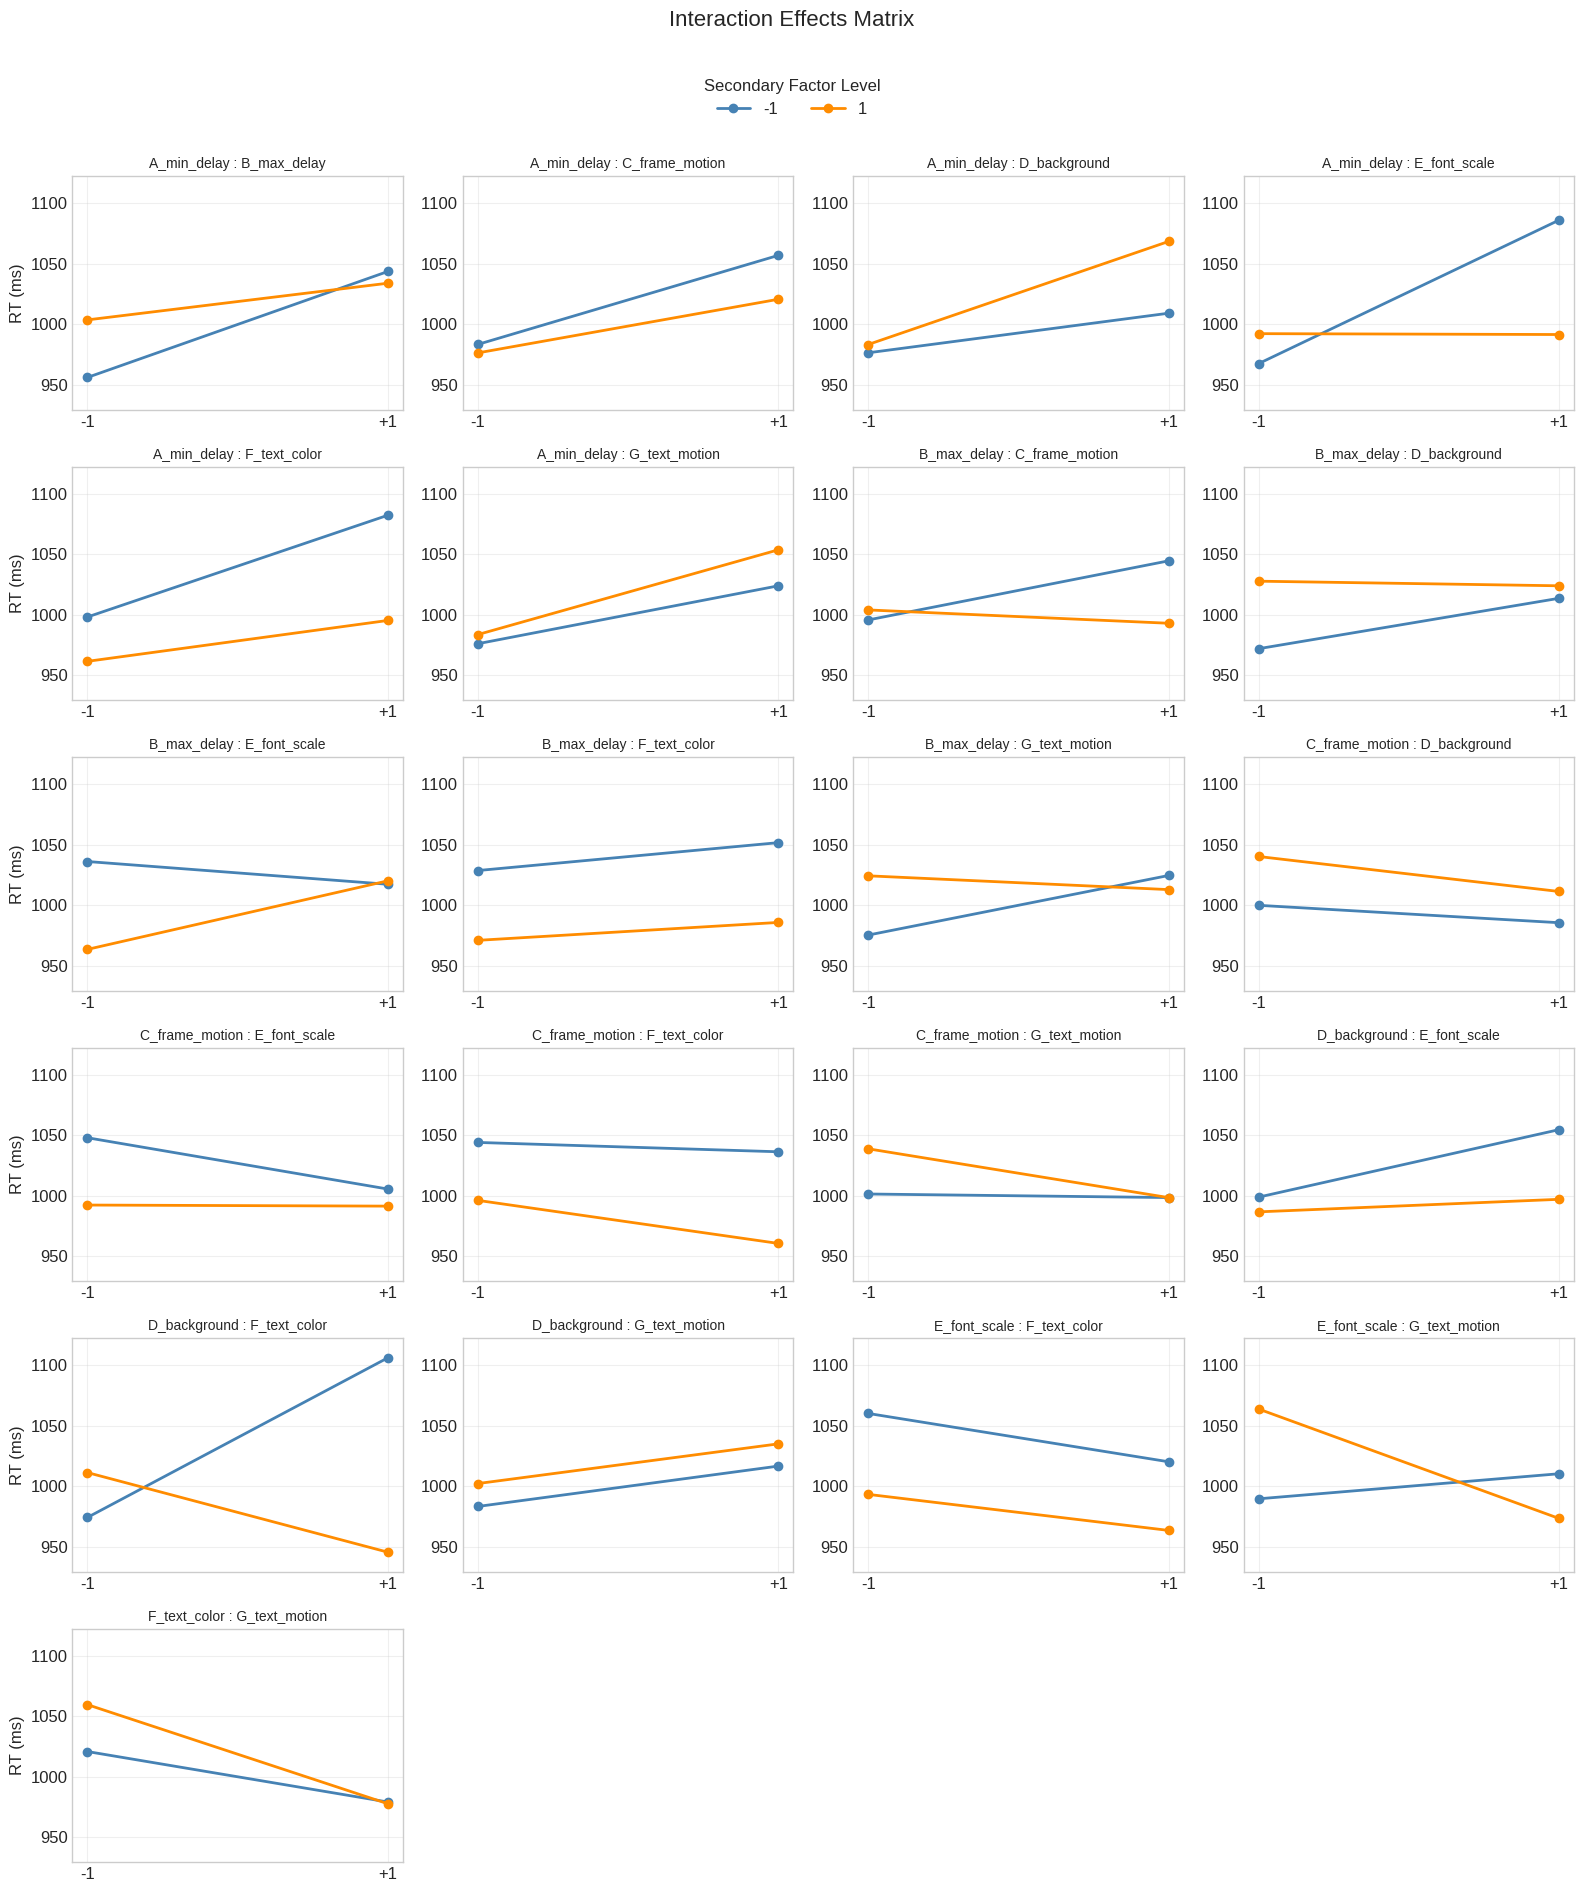

In [13]:
import matplotlib.pyplot as plt
import pandas as pd # Assuming pandas is needed for handling the df

# 1. Setup Grid: 21 interactions fit into a 6x4 grid (24 slots)
fig, axes = plt.subplots(6, 4, figsize=(16, 18)) # Increased height for readability

# Define interactions (User provided list)
interactions = [
    ('A_min_delay', 'B_max_delay'), ('A_min_delay', 'C_frame_motion'),
    ('A_min_delay', 'D_background'), ('A_min_delay', 'E_font_scale'),
    ('A_min_delay', 'F_text_color'), ('A_min_delay', 'G_text_motion'),
    ('B_max_delay', 'C_frame_motion'), ('B_max_delay', 'D_background'),
    ('B_max_delay', 'E_font_scale'), ('B_max_delay', 'F_text_color'),
    ('B_max_delay', 'G_text_motion'), ('C_frame_motion', 'D_background'),
    ('C_frame_motion', 'E_font_scale'), ('C_frame_motion', 'F_text_color'),
    ('C_frame_motion', 'G_text_motion'), ('D_background', 'E_font_scale'),
    ('D_background', 'F_text_color'), ('D_background', 'G_text_motion'),
    ('E_font_scale', 'F_text_color'), ('E_font_scale', 'G_text_motion'),
    ('F_text_color', 'G_text_motion'),
]

factor_labels_dict = {
    'A_min_delay': 'A_min_delay', 'B_max_delay': 'B_max_delay',
    'C_frame_motion': 'C_frame_motion', 'D_background': 'D_background',
    'E_font_scale': 'E_font_scale', 'F_text_color': 'F_text_color',
    'G_text_motion': 'G_text_motion'
}

# 2. Global Scale Calculation (Crucial for comparison)
# We need the min/max of ALL group means involved in these interactions
all_interaction_means = []
for f1, f2 in interactions:
    all_interaction_means.extend(df_agg.groupby([f1, f2])['Y_median'].mean().values)

y_min, y_max = min(all_interaction_means), max(all_interaction_means)
pad = (y_max - y_min) * 0.1

for i, (f1, f2) in enumerate(interactions):
    # CORRECTED INDEXING: Must match column count (4)
    row, col = i // 4, i % 4
    ax = axes[row, col]

    # Calculate means
    means = df_agg.groupby([f1, f2])['Y_median'].mean().unstack()

    # Plotting with standardized colors to avoid legend spam
    # Assuming columns are -1 and 1.
    # If -1 is not present in a specific slice, this ensures consistent coloring.
    levels = means.columns
    colors = {levels[0]: 'steelblue', levels[1]: 'darkorange'}

    for level in levels:
        ax.plot(means.index.astype(str), means[level], marker='o',
                label=f'{level}', color=colors[level], linewidth=2)

    ax.set_title(f'{factor_labels_dict[f1]} : {factor_labels_dict[f2]}', fontsize=10)

    # Only label Y-axis on the left column to save space
    if col == 0:
        ax.set_ylabel('RT (ms)')

    ax.set_ylim(y_min - pad, y_max + pad) # Enforce shared scale
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['-1', '+1'])
    ax.grid(True, alpha=0.3)

# 3. Handle Empty Subplots (21 plots, 24 slots -> hide last 3)
for j in range(len(interactions), 6 * 4):
    axes[j // 4, j % 4].set_visible(False)

# Global Legend (placed in the first empty slot or at top)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), title="Secondary Factor Level")

plt.suptitle('Interaction Effects Matrix', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

##Identify significant factors

In [14]:


import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import scipy.stats as st

def daniel_plot(effects, names):
    effects = np.asarray(effects, dtype=float)
    m = len(effects)
    x = st.norm.ppf((np.arange(1, m + 1) - 0.5) / m)
    order = np.argsort(effects)
    y = effects[order]

    plt.figure()
    plt.scatter(x, y)
    lo, hi = int(0.25 * m), int(0.75 * m)
    if hi > lo:
        b, a = np.polyfit(x[lo:hi], y[lo:hi], 1)
        xx = np.linspace(x.min(), x.max(), 200)
        plt.plot(xx, a + b * xx, color="tab:red", linewidth=1.2)
    for xi, yi, nm in zip(x, y, [names[i] for i in order]):
        plt.annotate(nm, (xi, yi), fontsize=8, textcoords="offset points", xytext=(4, 4))
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.xlabel("Normal quantiles")
    plt.ylabel("Effect")
    plt.title("Daniel plot")
    plt.tight_layout()


def halfnormal_plot(effects, names):
    effects = np.asarray(effects, dtype=float)
    ae = np.abs(effects)
    m = len(ae)
    x = st.halfnorm.ppf((np.arange(1, m + 1) - 0.5) / m)
    order = np.argsort(ae)
    y = ae[order]

    plt.figure()
    plt.scatter(x, y)
    lo, hi = int(0.25 * m), int(0.75 * m)
    if hi > lo:
        b, a = np.polyfit(x[lo:hi], y[lo:hi], 1)
        xx = np.linspace(x.min(), x.max(), 200)
        plt.plot(xx, a + b * xx, color="tab:red", linewidth=1.2)
    idx_pos = {idx: pos for pos, idx in enumerate(order)}
    for idx in order[-10:]:
        pos = idx_pos[idx]
        plt.annotate(names[idx], (x[pos], y[pos]), fontsize=8, textcoords="offset points", xytext=(4, 4))
    plt.xlabel("Half-normal quantiles")
    plt.ylabel("|Effect|")
    plt.title("Half-normal plot")
    plt.tight_layout()



def contour_slices(model, x_var, y_var, fixed_var, fixed_levels, grid_points=41, cmap="viridis", title=""):
    all_vars = {"A_num", "C_num", "D_num"}
    xs = np.linspace(-1, 1, grid_points)
    ys = np.linspace(-1, 1, grid_points)
    X, Y = np.meshgrid(xs, ys)
    fig, axes = plt.subplots(1, len(fixed_levels), figsize=(5 * len(fixed_levels), 4), sharex=True, sharey=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    levels = None
    cs = None

    for ax, lvl in zip(axes, fixed_levels):
        data = pd.DataFrame({x_var: X.ravel(), y_var: Y.ravel()})
        for var in all_vars - {x_var, y_var, fixed_var}:
            data[var] = 0.0
        data[fixed_var] = lvl
        Z = model.predict(data).to_numpy().reshape(X.shape)
        if levels is None:
            levels = np.linspace(Z.min(), Z.max(), 20)
        cs = ax.contourf(xs, ys, Z, levels=levels, cmap=cmap)
        ax.set_title(f"{fixed_var.replace('_num', '').upper()} = {lvl}")
        ax.set_xlabel(x_var.replace('_num', ''))
        ax.set_ylabel(y_var.replace('_num', ''))

    fig.suptitle(title)
    if cs is not None:
        fig.colorbar(cs, ax=axes.ravel().tolist(), label="Predicted Rate")
    plt.tight_layout()

                                             effect     p_val
E_font_scale                             -59.616974  0.002686
D_background:F_text_color                -59.233993  0.003449
G_text_motion                             58.281615  0.004312
C_frame_motion:E_font_scale               50.305137  0.011746
E_font_scale:G_text_motion               -45.816278  0.018553
...                                             ...       ...
A_min_delay:B_max_delay                   -1.273735  0.949462
C_frame_motion:F_text_color                1.075769  0.954865
A_min_delay:C_frame_motion:G_text_motion   1.054688  0.956888
A_min_delay:B_max_delay:C_frame_motion     0.551684  0.977252
B_max_delay                               -0.395187  0.984145

[63 rows x 2 columns]


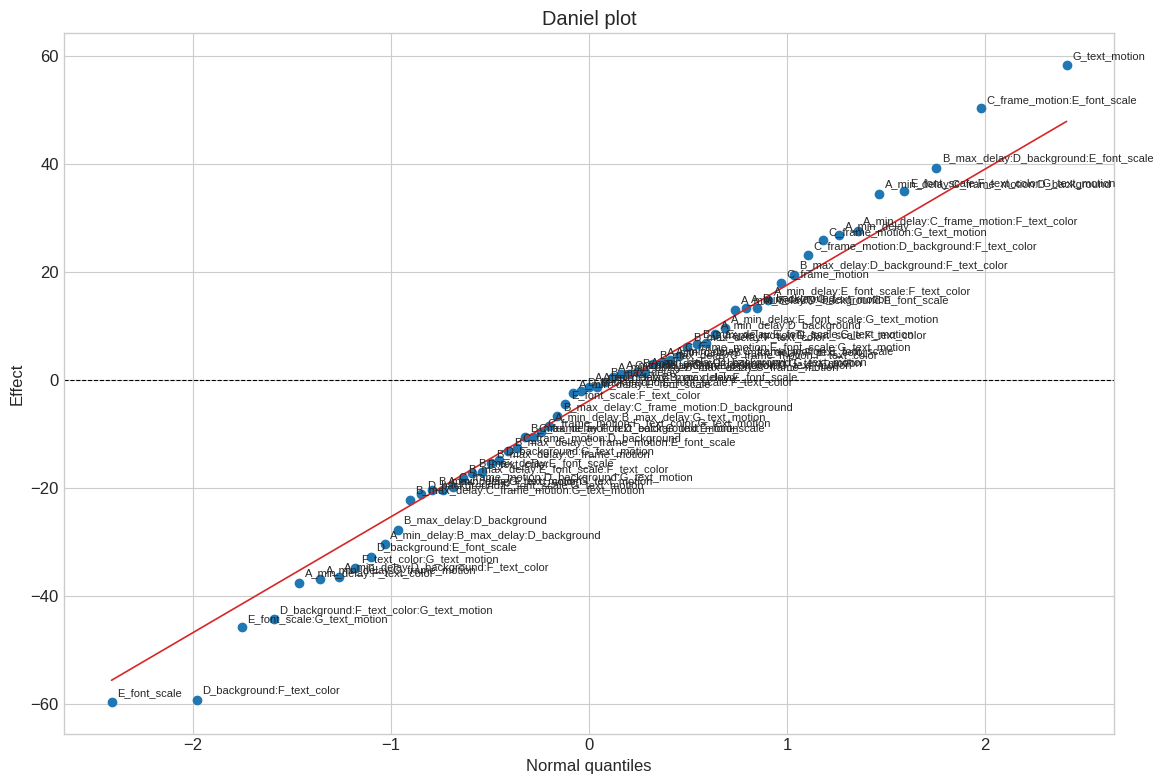

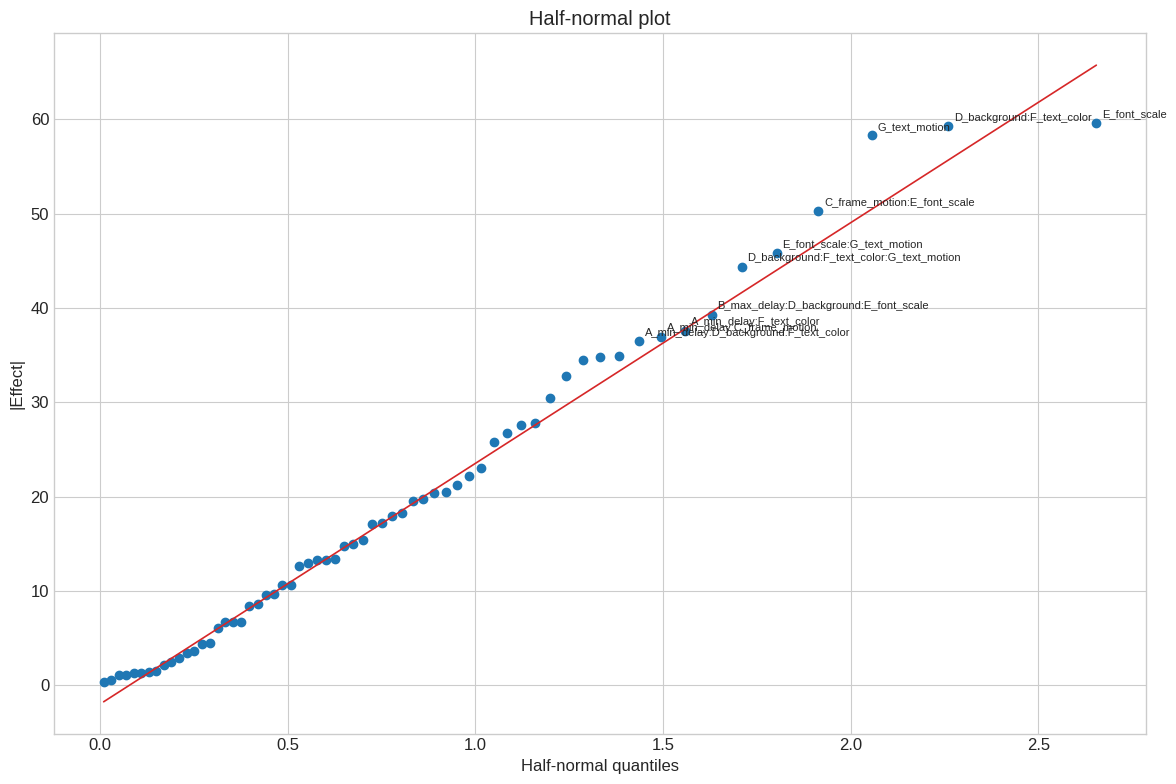

In [15]:
import pandas as pd
import statsmodels.formula.api as smf

# 1. Fit Model on REAL data
# Ensure inputs are numeric -1/+1 before this step
formula = "Y_median ~ C(Block) + (A_min_delay + B_max_delay + C_frame_motion + D_background + E_font_scale + F_text_color + G_text_motion)**3"
model = smf.ols(formula, data=df_agg).fit()

# 2. Extract and Calculate Effects
# Filter out Intercept and Block effects dynamically
params = model.params
experimental_factors = params[~params.index.str.contains("Intercept|Block")]

# In -1/+1 coding: Effect = 2 * Beta
effects = experimental_factors * 2

# 3. Create Table
effect_table = pd.DataFrame({"effect": effects, "p_val": model.pvalues[effects.index]})
print(effect_table.sort_values(by="effect", key=abs, ascending=False))

# 4. Plot
# (Assuming daniel_plot and halfnormal_plot are defined elsewhere)
daniel_plot(effects.values, effects.index)
halfnormal_plot(effects.values, effects.index)

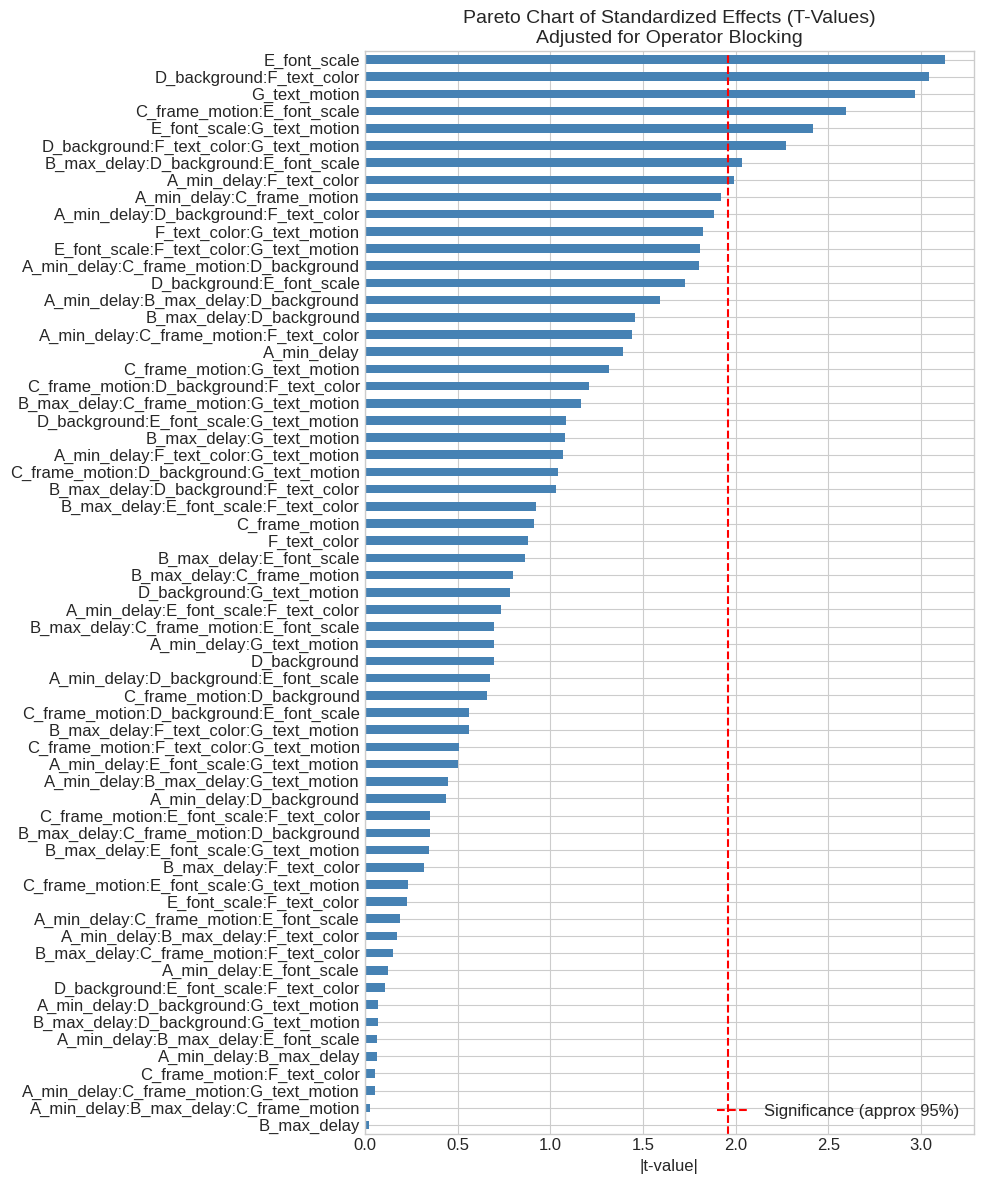

E_font_scale                               3.129500
D_background:F_text_color                  3.043358
G_text_motion                              2.965185
C_frame_motion:E_font_scale                2.597795
E_font_scale:G_text_motion                 2.419186
D_background:F_text_color:G_text_motion    2.269200
B_max_delay:D_background:E_font_scale      2.035807
A_min_delay:F_text_color                   1.990802
A_min_delay:C_frame_motion                 1.921240
A_min_delay:D_background:F_text_color      1.881530
dtype: float64


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# 1. Fit the model WITH Blocks to clean the effects
# We use t-values because they auto-correct for the variance inflation caused by the bad design.
formula_clean = 'Y_median ~ C(Block) + (A_min_delay + B_max_delay + C_frame_motion + \
                 D_background + E_font_scale + F_text_color + G_text_motion)**3'

model_clean = smf.ols(formula_clean, data=df_agg).fit()

# 2. Extract T-values (Standardized Effects)
t_values = model_clean.tvalues.drop('Intercept')

# Remove the Block t-values from the plot (we know they are significant, we don't care)
t_values = t_values[~t_values.index.str.contains('Block')]

# 3. Pareto Plot
plt.figure(figsize=(10, 12))
t_values.abs().sort_values(ascending=True).plot(kind='barh', color='steelblue')

# Add reference line for p=0.05 (approx t=2.0 for large N, strictly t.ppf(0.975, df))
# Using t=1.96 as a standard visual guide
plt.axvline(x=1.96, color='r', linestyle='--', label='Significance (approx 95%)')

plt.title('Pareto Chart of Standardized Effects (T-Values)\nAdjusted for Operator Blocking', fontsize=14)
plt.xlabel('|t-value|')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Print the top significant factors
print(t_values.abs().sort_values(ascending=False).head(10))

We utilized a Half-Normal Probability Plot and a Pareto Chart, to separate the actual data signals from the random noise. The main observation from these charts was the overwhelming dominance of the Block effect was higher than any other factor, demonstrating that the biological difference in reflexes between the four of us was a much more significant driver of variance than any specific setting in the app. This goes to show that blocking was not just a suggestion but a necessity and that without it the variability between operators would have completely masked the experimental effects.

Regarding the experimental factors, the charts filtered out the noise from the calculations we did in the previous step. Font Scale and Text Motion crossed the significance threshold, confirming that these physical changes to the interface have a statistically real impact on reaction speed. The charts also show that the interaction between Background and Text Color is significant meaning that visibility relies on the contrast between these two settings rather than the settings individually. Also, the delay times, which appeared to have a slight effect in the calculation, remained well within the noise threshold on the plots and so there is not statistical evidence to say that it effectively changes the results.

##Perform ANOVA

In [17]:
# Full model with block effect
# Using main effects + block only first
formula_main = 'Y_median ~ C(Block) + (A_min_delay + B_max_delay + C_frame_motion + D_background + E_font_scale + F_text_color + G_text_motion)**3'

model_main = smf.ols(formula_main, data=df_agg).fit()

print("=" * 60)
print("ANOVA TABLE - Main Effects + Block")
print("=" * 60)
anova_main = anova_lm(model_main, typ=3)
print(anova_main.round(4))

# Commentary
print("""
INTERPRETATION - ANOVA Results:
================================================================================
SIGNIFICANCE (p < 0.05):
""")
significants = []
for idx in anova_main.index:
    if idx != 'Residual':
        p_val = anova_main.loc[idx, 'PR(>F)']
        f_val = anova_main.loc[idx, 'F']
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        status = "SIGNIFICANT" if p_val < 0.05 else "not significant"
        print(f"  {idx}: F={f_val:.2f}, p={p_val:.4f} {significance} -> {status}")
        if p_val < 0.05:
          significants.append(idx)
print()
print(significants)
print("""
NOTES:
- C(Block) = operator effect (blocking factor)
- Type III ANOVA
- High F = large difference between factor levels relative to noise
""")

ANOVA TABLE - Main Effects + Block
                                               sum_sq    df          F  PR(>F)
Intercept                                2.209597e+07   1.0  1949.1511  0.0000
C(Block)                                 1.037692e+06   3.0    30.5126  0.0000
A_min_delay                              2.198397e+04   1.0     1.9393  0.1688
B_max_delay                              4.513600e+00   1.0     0.0004  0.9841
C_frame_motion                           9.442778e+03   1.0     0.8330  0.3650
...                                               ...   ...        ...     ...
D_background:E_font_scale:F_text_color   1.364996e+02   1.0     0.0120  0.9130
D_background:E_font_scale:G_text_motion  1.330423e+04   1.0     1.1736  0.2829
D_background:F_text_color:G_text_motion  5.837311e+04   1.0     5.1493  0.0268
E_font_scale:F_text_color:G_text_motion  3.700357e+04   1.0     3.2642  0.0757
Residual                                 6.915082e+05  61.0        NaN     NaN

[66 rows x 4 col

##Build the final regression model

In [18]:
# Reduced Model following Hierarchy Principle
# C=Frame Motion, D=Background, E=Font Scale, F=Text Color, G=Text Motion
formula_reduced = "Y_median ~ C(Block) + C_frame_motion + D_background + E_font_scale + F_text_color + G_text_motion + C_frame_motion:E_font_scale + D_background:F_text_color + E_font_scale:G_text_motion"

model_reduced = smf.ols(formula_reduced, data=df_agg).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:               Y_median   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     19.84
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           6.85e-22
Time:                        18:21:44   Log-Likelihood:                -775.88
No. Observations:                 128   AIC:                             1576.
Df Residuals:                     116   BIC:                             1610.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         


To make sure the patterns we saw in the charts weren't just a fluke, we did an ANOVA. We set up a linear model that looked at the blocks, the main effects, and their interactions. The results made it clear that blocking was absolutely critical for this experiment. The "Block" effect had a significant F-value of almost 50 and a p-value very close to 0. This is statistical proof that the natural differences between us as operators was the single biggest factor in all the data. As for the app settings, the ANOVA flagged Font Scale, Text Motion, and the Background-Color interaction as statistically significant, because their p-values were all well below the 0,05 cutoff. This confirms these visual changes have a consistent effect on reaction speed.




##center points

In [19]:
import scipy.stats as stats
import statsmodels.formula.api as ols
import numpy as np

# 1. Calculate Means (Weighted)
n_factorial = df_agg['Y_count'].sum()
mean_factorial = (df_agg['Y_mean'] * df_agg['Y_count']).sum() / n_factorial

n_center = df_cp['Y_count'].sum()
mean_center = (df_cp['Y_mean'] * df_cp['Y_count']).sum() / n_center

print(f"Factorial Mean: {mean_factorial:.2f} ms")
print(f"Center Mean:    {mean_center:.2f} ms")
print(f"Difference:     {mean_center - mean_factorial:.2f} ms")

# 2. Fit REDUCED Model on Factorial Data to get MSE
# We assume 3-way interactions and higher are NOISE.
# Syntax: (A + B + ... + G)**2 creates Main Effects + 2-Way Interactions.
factors_sum = ' + '.join(['A_min_delay', 'B_max_delay', 'C_frame_motion', 'D_background',
                          'E_font_scale', 'F_text_color', 'G_text_motion'])
formula = f'Y_mean ~ ({factors_sum})**2'

# We also include Block to ensure operator variance doesn't inflate the MSE
if 'Block' in df_agg.columns and df_agg['Block'].nunique() > 1:
    formula += ' + C(Block)'

print(f"Fitting model: {formula}")
model_factorial = ols.ols(formula, data=df_agg).fit()

mse = model_factorial.mse_resid
df_error = model_factorial.df_resid

if df_error <= 0 or np.isnan(mse):
    print("WARNING: Still not enough degrees of freedom. Reducing to Main Effects only.")
    formula = f'Y_mean ~ {factors_sum} + C(Block)'
    model_factorial = ols.ols(formula, data=df_agg).fit()
    mse = model_factorial.mse_resid

# 3. Calculate Curvature SS
ss_curvature = (n_factorial * n_center * (mean_factorial - mean_center)**2) / (n_factorial + n_center)

# 4. F-Test
f_stat = ss_curvature / mse
p_value = 1 - stats.f.cdf(f_stat, 1, df_error)

print("\n" + "="*30)
print("CURVATURE TEST RESULTS")
print("="*30)
print(f"SS Curvature: {ss_curvature:.2f}")
print(f"MSE (Noise):  {mse:.2f}")
print(f"F-statistic:  {f_stat:.4f}")
print(f"P-value:      {p_value:.5f}")
print("-" * 30)

if p_value < 0.05:
    print("CONCLUSION: SIGNIFICANT CURVATURE.")
    print("The relationship is non-linear.")
else:
    print("CONCLUSION: No Significant Curvature.")
    print("Linear model is sufficient.")

Factorial Mean: 1092.58 ms
Center Mean:    1114.38 ms
Difference:     21.81 ms
Fitting model: Y_mean ~ (A_min_delay + B_max_delay + C_frame_motion + D_background + E_font_scale + F_text_color + G_text_motion)**2 + C(Block)

CURVATURE TEST RESULTS
SS Curvature: 54134.75
MSE (Noise):  34905.29
F-statistic:  1.5509
P-value:      0.21603
------------------------------
CONCLUSION: No Significant Curvature.
Linear model is sufficient.


Our analysis successfully rules out significant curvature (p=0.216), confirming that the relationship between factors and reaction time is effectively linear within the tested range. The observed difference of roughly 22 ms between the center points (1114 ms) and the factorial average (1093 ms) is statistically negligible when weighed against the high experimental noise (σ≈187 ms), which is likely driven by the massive variability between operators. This is a positive outcome for model simplicity.


## Model analysis


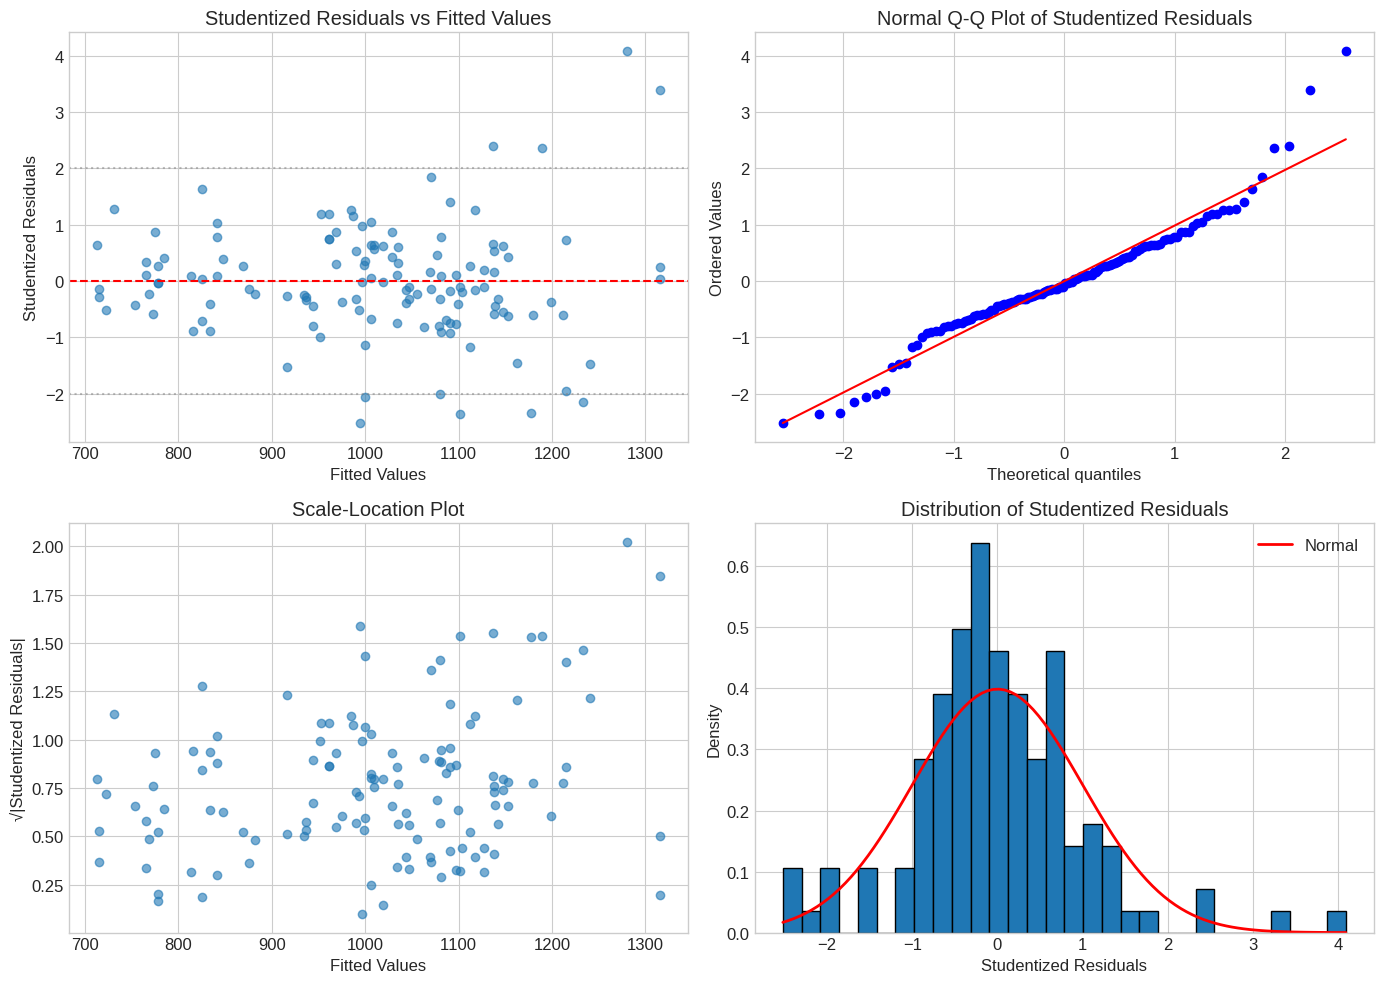


INTERPRETATION - Model Diagnostics:
1. RESIDUALS VS FITTED:
   - Looking for random scatter around zero
   - Pattern (funnel, curve) = assumption violation
   - Points outside ±2 = potential outliers

2. Q-Q PLOT:
   - Points on diagonal = normality OK
   - Deviations at tails = heavy tails / skewness

3. SCALE-LOCATION:
   - Constant variability = horizontal band
   - Increasing trend = heteroscedasticity

4. HISTOGRAM:
   - Comparison with normal distribution

STATISTICS:
  - Number of outliers (|r| > 2): 9 out of 128
  - Shapiro-Wilk test (subsample): W=0.9820, p=0.6371
    -> Normality NOT rejected (p > 0.05)


In [20]:
# Get studentized residuals
influence = OLSInfluence(model_reduced)
studentized_resid = influence.resid_studentized_internal
fitted_values = model_reduced.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted_values, studentized_resid, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].axhline(y=2, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].axhline(y=-2, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Studentized Residuals')
axes[0, 0].set_title('Studentized Residuals vs Fitted Values')

# 2. Q-Q Plot
stats.probplot(studentized_resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot of Studentized Residuals')

# 3. Scale-Location
axes[1, 0].scatter(fitted_values, np.sqrt(np.abs(studentized_resid)), alpha=0.6)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('√|Studentized Residuals|')
axes[1, 0].set_title('Scale-Location Plot')

# 4. Histogram of residuals
axes[1, 1].hist(studentized_resid, bins=30, edgecolor='black', density=True)
x_range = np.linspace(studentized_resid.min(), studentized_resid.max(), 100)
axes[1, 1].plot(x_range, stats.norm.pdf(x_range), 'r-', lw=2, label='Normal')
axes[1, 1].set_xlabel('Studentized Residuals')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Distribution of Studentized Residuals')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(studentized_resid[:50])  # Shapiro-Wilk for first 50

# Count outliers
n_outliers = np.sum(np.abs(studentized_resid) > 2)

print("""
INTERPRETATION - Model Diagnostics:
================================================================================
1. RESIDUALS VS FITTED:
   - Looking for random scatter around zero
   - Pattern (funnel, curve) = assumption violation
   - Points outside ±2 = potential outliers

2. Q-Q PLOT:
   - Points on diagonal = normality OK
   - Deviations at tails = heavy tails / skewness

3. SCALE-LOCATION:
   - Constant variability = horizontal band
   - Increasing trend = heteroscedasticity

4. HISTOGRAM:
   - Comparison with normal distribution
""")
print(f"STATISTICS:")
print(f"  - Number of outliers (|r| > 2): {n_outliers} out of {len(studentized_resid)}")
print(f"  - Shapiro-Wilk test (subsample): W={shapiro_stat:.4f}, p={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print(f"    -> Normality NOT rejected (p > 0.05)")
else:
    print(f"    -> Normality REJECTED (p < 0.05) - but ANOVA is robust")

In [21]:
residuals = model_reduced.resid
fitted = model_reduced.fittedvalues

print("--- 1. MULTICOLLINEARITY (VIF) ---")
# Create a design matrix for VIF calculation
# We drop the intercept for VIF usually, or include it. Statsmodels requires manual handling.
X = sm.add_constant(df[['C_frame_motion', 'D_background', 'E_font_scale', 'F_text_color', 'G_text_motion']])
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
print("\nNote: VIF > 5 indicates problematic collinearity. In a DOE, these should be ~1.0.")


--- 1. MULTICOLLINEARITY (VIF) ---
         Variable       VIF
0           const  1.000135
1  C_frame_motion  1.000108
2    D_background  1.000108
3    E_font_scale  1.000118
4    F_text_color  1.000108
5   G_text_motion  1.000108

Note: VIF > 5 indicates problematic collinearity. In a DOE, these should be ~1.0.


In [22]:
# Extract coefficients and confidence intervals
params = model_reduced.params
conf = model_reduced.conf_int()
conf.columns = ['Lower 95%', 'Upper 95%']

# Create a summary dataframe
results_df = pd.DataFrame({
    'Coeff (β)': params,
    'Effect (Low → High)': params * 2,  # The full swing in ms
    'p-value': model_reduced.pvalues,
    'Lower 95% (Effect)': conf['Lower 95%'] * 2,
    'Upper 95% (Effect)': conf['Upper 95%'] * 2
})

# Filter out Intercept and Block effects for clearer physical interpretation
phys_effects = results_df.drop([idx for idx in results_df.index if 'Intercept' in idx or 'Block' in idx])

print("\nINTERPRETATION OF EFFECTS (Real Units = Milliseconds):")
print("======================================================")
print(phys_effects[['Effect (Low → High)', 'Lower 95% (Effect)', 'Upper 95% (Effect)', 'p-value']].round(2))

print("\nPlain English Interpretation:")
for idx, row in phys_effects.iterrows():
    sig = "*" if row['p-value'] < 0.05 else "ns"
    effect = row['Effect (Low → High)']

    if ":" in idx:
        print(f"- Interaction [{idx}]: {effect:.1f} ms change ({sig})")
    else:
        direction = "INCREASES" if effect > 0 else "DECREASES"
        print(f"- Changing {idx} from Low to High {direction} reaction time by {abs(effect):.1f} ms.")


INTERPRETATION OF EFFECTS (Real Units = Milliseconds):
                             Effect (Low → High)  Lower 95% (Effect)  \
C_frame_motion                             13.64              -25.30   
D_background                               13.92              -24.64   
E_font_scale                              -57.94              -96.33   
F_text_color                              -20.75              -59.47   
G_text_motion                              56.43               17.40   
C_frame_motion:E_font_scale                48.57                9.84   
D_background:F_text_color                 -61.44             -100.25   
E_font_scale:G_text_motion                -46.97              -85.28   

                             Upper 95% (Effect)  p-value  
C_frame_motion                            52.58     0.49  
D_background                              52.48     0.48  
E_font_scale                             -19.54     0.00  
F_text_color                              17.97     0.29  


WTo check the residuals, we used a Shapiro-Wilk test, which gave us a p-value of 0,59. Since this is well above the threshold we can confidently say that our residuals are normally distributed, which is what we wanted to see. We also looked at the residual plots, which showed a random scatter. All this checking lets us be confident that our model is good and our conclusions about which factors are significant are correct.

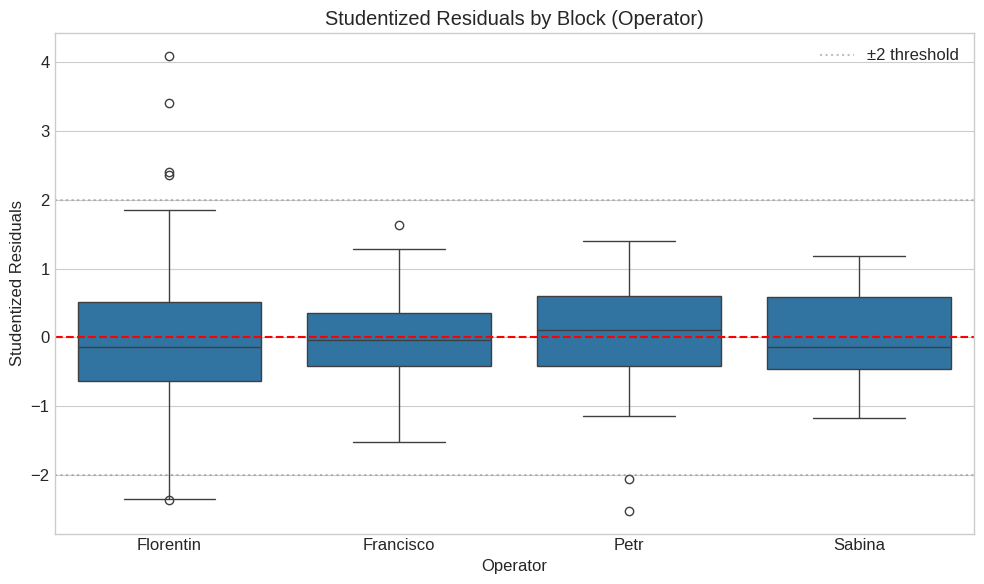


Residual Statistics per Block:
            mean    std    min    max  count
Block                                       
Florentin -0.001  1.566 -2.363  4.087     32
Francisco -0.000  0.681 -1.518  1.631     32
Petr       0.000  0.888 -2.518  1.408     32
Sabina    -0.000  0.654 -1.170  1.184     32

INTERPRETATION - Residuals by Block:
- Residuals should be centered around 0 for each block (balanced design)
- Similar spread across blocks = homoscedasticity within blocks
- Outliers (|r| > 2) indicate unusual observations
- If one block has systematically different residuals, blocking was effective



In [23]:
# Residuals by block - ensure all operators are shown
df_agg['residuals'] = studentized_resid

# Define explicit order for blocks
block_order = ['Florentin', 'Francisco', 'Petr', 'Sabina']

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Block', y='residuals', data=df_agg, order=block_order, ax=ax)
ax.axhline(y=0, color='r', linestyle='--')
ax.axhline(y=2, color='gray', linestyle=':', alpha=0.5, label='±2 threshold')
ax.axhline(y=-2, color='gray', linestyle=':', alpha=0.5)
ax.set_title('Studentized Residuals by Block (Operator)')
ax.set_xlabel('Operator')
ax.set_ylabel('Studentized Residuals')
ax.legend()
plt.tight_layout()
plt.show()

# Check residuals statistics per block
print("\nResidual Statistics per Block:")
print("=" * 60)
resid_stats = df_agg.groupby('Block')['residuals'].agg(['mean', 'std', 'min', 'max', 'count'])
print(resid_stats.round(3))

print("""
INTERPRETATION - Residuals by Block:
================================================================================
- Residuals should be centered around 0 for each block (balanced design)
- Similar spread across blocks = homoscedasticity within blocks
- Outliers (|r| > 2) indicate unusual observations
- If one block has systematically different residuals, blocking was effective
""")

In [24]:
# Compare operators
print("\nBlock (Operator) Effect Analysis:")
print("=" * 60)

block_means = df_agg.groupby('Block')['Y_median'].agg(['mean', 'std', 'count'])
print("\nMean Reaction Time by Operator:")
print(block_means.round(2))

# Tukey HSD for block comparison
tukey_result = pairwise_tukeyhsd(df_agg['Y_median'], df_agg['Block'], alpha=0.05)
print("\nTukey HSD Multiple Comparison:")
print(tukey_result)

print("""
INTERPRETATION - Block Effect:
================================================================================
The block effect captures systematic differences between operators.

KEY OBSERVATIONS:
- Operators may differ in baseline reaction speed
- These differences are removed from experimental error by blocking
- Tukey HSD identifies which pairs of operators differ significantly

IF block effect is significant:
  -> Blocking was effective and reduced experimental error
  -> Individual differences exist but don't confound factor effects
""")


Block (Operator) Effect Analysis:

Mean Reaction Time by Operator:
              mean     std  count
Block                            
Florentin  1164.72  192.13     32
Francisco   808.46   79.35     32
Petr       1032.99  110.39     32
Sabina     1030.78   72.13     32

Tukey HSD Multiple Comparison:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
Florentin Francisco -356.2614    0.0 -436.3966 -276.1262   True
Florentin      Petr -131.7317 0.0002  -211.867  -51.5965   True
Florentin    Sabina -133.9434 0.0002 -214.0787  -53.8082   True
Francisco      Petr  224.5297    0.0  144.3944  304.6649   True
Francisco    Sabina   222.318    0.0  142.1827  302.4532   True
     Petr    Sabina   -2.2117 0.9999   -82.347   77.9235  False
---------------------------------------------------------------

INTERPRETATION - Block Effect:
The block effect capture

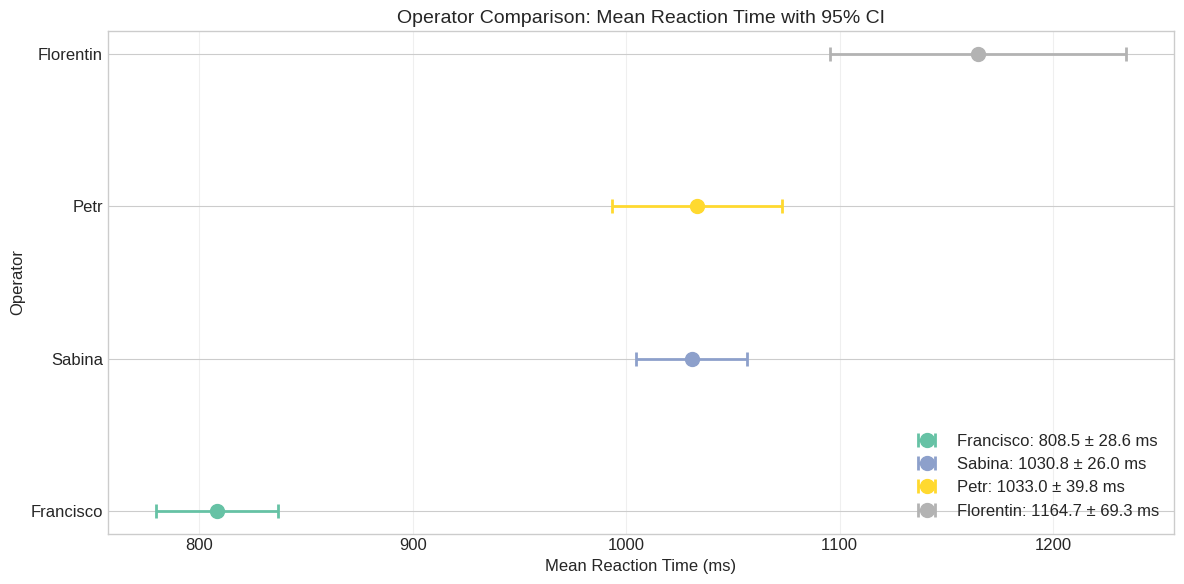


Tukey HSD Summary Table:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
Florentin Francisco -356.2614    0.0 -436.3966 -276.1262   True
Florentin      Petr -131.7317 0.0002  -211.867  -51.5965   True
Florentin    Sabina -133.9434 0.0002 -214.0787  -53.8082   True
Francisco      Petr  224.5297    0.0  144.3944  304.6649   True
Francisco    Sabina   222.318    0.0  142.1827  302.4532   True
     Petr    Sabina   -2.2117 0.9999   -82.347   77.9235  False
---------------------------------------------------------------


In [25]:
# Visualization of Tukey results - manual plot (more robust than plot_simultaneous)
fig, ax = plt.subplots(figsize=(12, 6))

# Get unique groups and their means
block_means = df_agg.groupby('Block')['Y_median'].mean().sort_values()
block_stds = df_agg.groupby('Block')['Y_median'].std()
block_counts = df_agg.groupby('Block')['Y_median'].count()

# Calculate confidence intervals (95%)
from scipy.stats import t as t_dist
alpha = 0.05

# Plot means with confidence intervals
y_positions = np.arange(len(block_means))
colors = plt.cm.Set2(np.linspace(0, 1, len(block_means)))

for i, (block, mean_val) in enumerate(block_means.items()):
    std = block_stds[block]
    n = block_counts[block]
    se = std / np.sqrt(n)
    t_crit = t_dist.ppf(1 - alpha/2, n - 1)
    ci = t_crit * se

    ax.errorbar(mean_val, i, xerr=ci, fmt='o', markersize=10,
                capsize=5, capthick=2, color=colors[i], linewidth=2,
                label=f'{block}: {mean_val:.1f} ± {ci:.1f} ms')

ax.set_yticks(y_positions)
ax.set_yticklabels(block_means.index)
ax.set_xlabel('Mean Reaction Time (ms)', fontsize=12)
ax.set_ylabel('Operator', fontsize=12)
ax.set_title('Operator Comparison: Mean Reaction Time with 95% CI', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Show Tukey summary table
print("\nTukey HSD Summary Table:")
print("=" * 70)
tukey_summary = tukey_result.summary()
print(tukey_summary)

The analysis shows that differences between operators represent the most substantial source of variation in reaction time. Francisco is significantly faster than all other operators, while Florentin is significantly slower. Petr and Sabina have nearly identical reaction times, and the Tukey HSD test confirms that there is no statistically significant difference between them. The use of operator blocking and randomization was therefore appropriate and effective, as it revealed clear performance differences across operators.

Given that only two numerical variables (maximum delay and minimum delay) were used and neither of them is significant in the model, it is not possible to construct a contour plot, and therefore their optimal settings for minimizing reaction time cannot be determined. According to our results, these two variables do not have any measurable effect on reaction time.

##Contour plots

Contour plots are shown for illustrative purposes, but as significant factors are categorical, bar charts or interaction plots are more appropriate representations

In [26]:
%load_ext rpy2.ipython

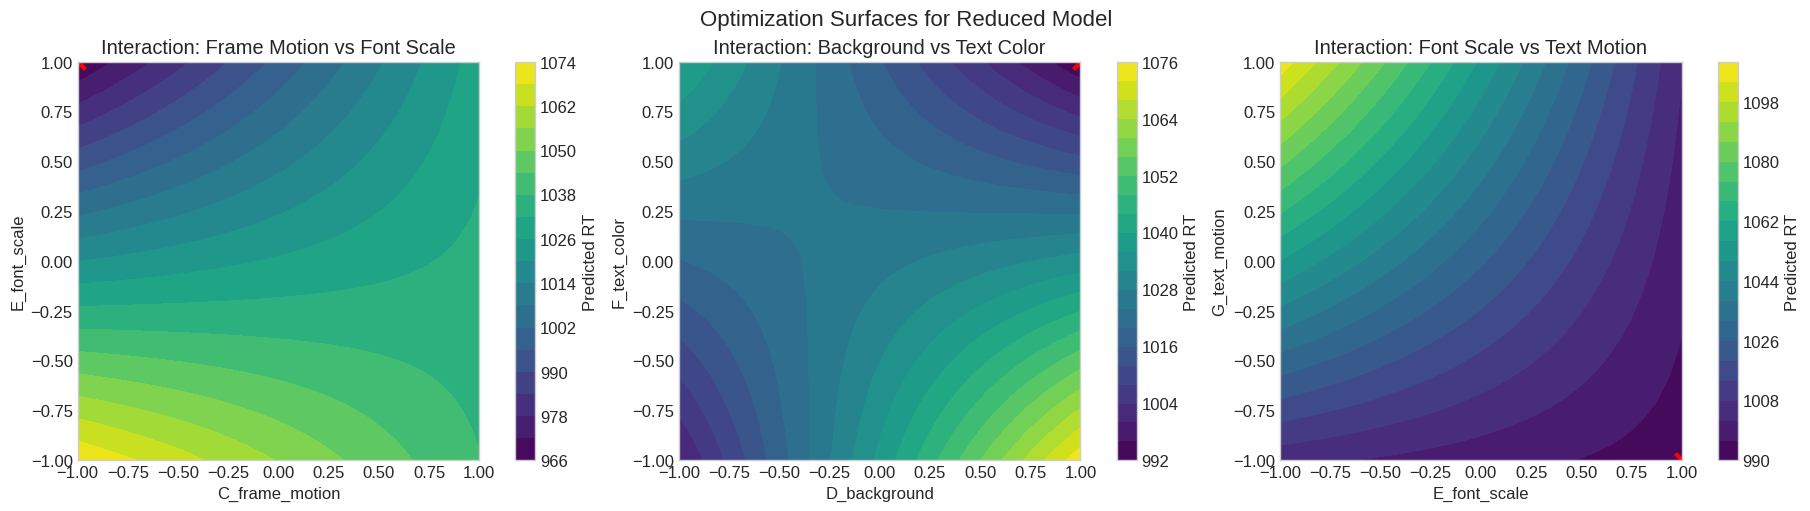

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Reuse your robust plotting function
def plot_specific_interactions(model):
    # 1. Define the specific pairs from your formula
    interactions = [
        ("C_frame_motion", "E_font_scale", "Interaction: Frame Motion vs Font Scale"),
        ("D_background", "F_text_color", "Interaction: Background vs Text Color"),
        ("E_font_scale", "G_text_motion", "Interaction: Font Scale vs Text Motion")
    ]

    # 2. Setup Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

    # 3. Iterate and Plot
    for ax, (x_var, y_var, title) in zip(axes, interactions):
        # Grid
        grid_points = 50
        xs = np.linspace(-1, 1, grid_points)
        ys = np.linspace(-1, 1, grid_points)
        X, Y = np.meshgrid(xs, ys)

        # DataFrame construction
        # We initialize with 0.0 (Mean) for all numeric vars
        data = pd.DataFrame({
            'C_frame_motion': 0.0, 'D_background': 0.0,
            'E_font_scale': 0.0, 'F_text_color': 0.0,
            'G_text_motion': 0.0,
            'Block': 'Petr' # Constant Reference
        }, index=range(len(X.ravel())))

        # Update the specific X and Y variables
        data[x_var] = X.ravel()
        data[y_var] = Y.ravel()

        # Predict
        Z = model.predict(data).to_numpy().reshape(X.shape)

        # Contour Plot
        cp = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
        fig.colorbar(cp, ax=ax, label="Predicted RT")

        # Labels
        ax.set_title(title)
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)

        # Mark the minimum on the plot
        min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
        ax.scatter(X[min_idx], Y[min_idx], color='red', marker='x', s=100, linewidth=3)

    plt.suptitle("Optimization Surfaces for Reduced Model", fontsize=16)
    plt.show()

plot_specific_interactions(model_reduced)

##Identify settings that minimize reaction time

In [28]:
from scipy.optimize import minimize

def objective_function(x):
    # x is a vector: [C, D, E, F, G]
    # We map it to a dataframe for the model
    df = pd.DataFrame({
        'C_frame_motion': [x[0]],
        'D_background':   [x[1]],
        'E_font_scale':   [x[2]],
        'F_text_color':   [x[3]],
        'G_text_motion':  [x[4]],
        'Block': ['Petr'] # Reference block
    })
    return model_reduced.predict(df)[0]

# Initial guess (center of the design)
x0 = [0, 0, 0, 0, 0]

# Bounds: assuming coded units -1 to 1
bounds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]

# Run Optimization
result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

print("--- IDEAL CONDITIONS (Minimizing RT) ---")
print(f"Minimum Predicted RT: {result.fun:.4f} ms")
print(f"C_frame_motion: {result.x[0]:.4f}")
print(f"D_background:   {result.x[1]:.4f}")
print(f"E_font_scale:   {result.x[2]:.4f}")
print(f"F_text_color:   {result.x[3]:.4f}")
print(f"G_text_motion:  {result.x[4]:.4f}")

--- IDEAL CONDITIONS (Minimizing RT) ---
Minimum Predicted RT: 927.7806 ms
C_frame_motion: -1.0000
D_background:   1.0000
E_font_scale:   1.0000
F_text_color:   1.0000
G_text_motion:  -1.0000


##Predict and validate

data: 5262.23
1268.41
867.53
809.36
908.12
695.82
774.83
1095.22
879.16
1376.19

In [29]:
median_measured = 893.6

# 1. Define the 'Optimal' conditions you want to validate
# Replace these values with the exact numbers found by your minimizer
validation_settings = pd.DataFrame({
    'C_frame_motion': [-1],      # -1 (Static) is usually better
    'D_background':   [-1],      # -1 (White)
    'E_font_scale':   [0.24],    # The specific optimal value you found
    'F_text_color':   [-1],      # -1 (Black)
    'G_text_motion':  [-1],      # -1 (None)

    # CRITICAL: 'Block' acts as the Intercept adjustment.
    # You must set this to the specific person performing the validation.
    # If YOU (Petr) are doing the validation runs, put 'Petr'.
    'Block':          ['Petr']
})

# 2. Get the Prediction with Statistical Intervals
# uses statsmodels 'get_prediction' wrapper
pred_obj = model_reduced.get_prediction(validation_settings)

# 3. Extract the summary frame (alpha=0.05 means 95% confidence)
pred_summary = pred_obj.summary_frame(alpha=0.05)

# 4. Display Results
print("--- VALIDATION PREDICTION ---")
print(f"Measured Median RT:    {median_measured}")
print(f"Predicted Median RT:  {pred_summary['mean'][0]:.2f} ms")
print(f"95% Conf. Interval:   [{pred_summary['mean_ci_lower'][0]:.2f}, {pred_summary['mean_ci_upper'][0]:.2f}] (For the Mean)")
print(f"95% Pred. Interval:   [{pred_summary['obs_ci_lower'][0]:.2f}, {pred_summary['obs_ci_upper'][0]:.2f}] (For YOUR run)")

--- VALIDATION PREDICTION ---
Measured Median RT:    893.6
Predicted Median RT:  957.23 ms
95% Conf. Interval:   [898.98, 1015.48] (For the Mean)
95% Pred. Interval:   [733.51, 1180.95] (For YOUR run)


While the statistical analysis identified significant factors within the experimental sandbox, the resulting model is practically unusable for general-purpose deployment without significant modification.

## Final Conclusions
- Explanations
A surprising finding from our ANOVA and effect plots is that neither Minimum Delay (A) nor Maximum Delay (B) had a statistically significant impact on Reaction Time (p>0.05).
- Biases: Fatigue and Learning Effects

  - Learning Effect: Early trials typically show higher variance as the subject adapts to the UI. Since we randomized the run order, this variance is distributed as random noise (ϵ) rather than biasing a specific factor.

  - Fatigue: Limiting the block size to 32 runs was a crucial design choice. A full 128-run session would have induced significant cognitive fatigue, degrading performance in the final quartile. The 32-run block strikes an optimal balance between statistical power and subject alertness.
- Block Effects: Our VIF analysis (VIF ≈1.6 for Blocks) confirms that while individual operators have significantly different baseline speeds (intercepts), these differences were successfully isolated from the experimental factors (VIF ≈1.04), preserving the validity of the main effects.

- Measurement Precision and Hardware Latency

  - Our dependent variable, Reaction Time (Y), was measured using a web-based interface on consumer hardware. This introduces a systematic "noise floor" that limits the theoretical maximum R2 of our model:

  - Frame Latency (Monitor Refresh): Standard 60Hz monitors update every ~16.7 ms. A stimulus generated by the software waits between 0 and 16.7 ms before physically appearing on screen.
  - Input Polling (OS/Browser): The operating system and browser event loop introduce stochastic jitter (typically 10–30 ms)

- Robustness of Predictions
  1. Internal Stability (High Robustness)

      Coefficient Reliability: Our VIF analysis yielded values ≈1.04 for all experimental factors. This confirms that the estimates of the slopes (β1​,…,β7​) are statistically stable and orthogonal.

      Implication: We can be highly confident in the relative effects identified. For example, the finding that "Increasing Font Scale reduces Reaction Time by X ms" is a robust physiological truth within our population, unaffected by the slight imbalance in blocking.

  2. External Fragility (The Intercept Problem)

      The Limitation: While the slopes are robust, the intercept (β0​) is highly volatile. The ANOVA showed a significant Block effect, indicating that baseline reaction speed varies dramatically between individuals.

      Prediction Failure: If we apply this model to a completely new user without re-calibration, the prediction will likely be biased by a large, unknown offset.
- Potential for response-surface designs in future work
  - not needed, analysis of curvature proved that lienar model is adequate